In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras.applications import DenseNet121
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,MaxPooling2D , Conv2D,Flatten
from tensorflow.keras.models import Sequential

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report


from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_dir = "../input/ucf-crime-dataset/Train"
test_dir = "../input/ucf-crime-dataset/Test"

SEED = 12
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 32
EPOCHS = 5
LR =  0.001

In [3]:
crime_types=os.listdir(train_dir)
n=len(crime_types)
print("Number of crime categories : ",n)

Number of crime categories :  14


In [4]:
crime_types

['RoadAccidents',
 'Assault',
 'Vandalism',
 'Arrest',
 'Shooting',
 'NormalVideos',
 'Arson',
 'Explosion',
 'Shoplifting',
 'Robbery',
 'Stealing',
 'Burglary',
 'Abuse',
 'Fighting']

Crimes have been catogarized in 14 different types.

In [5]:
crimes={}
train=test=0
for clss in crime_types:
    num=len(os.listdir(os.path.join(train_dir,clss)))
    train+=num
    test+=len(os.listdir(os.path.join(test_dir,clss)))
    
    crimes[clss]=num

In [6]:
crimes

{'RoadAccidents': 23486,
 'Assault': 10360,
 'Vandalism': 13626,
 'Arrest': 26397,
 'Shooting': 7140,
 'NormalVideos': 947768,
 'Arson': 24421,
 'Explosion': 18753,
 'Shoplifting': 24835,
 'Robbery': 41493,
 'Stealing': 44802,
 'Burglary': 39504,
 'Abuse': 19076,
 'Fighting': 24684}

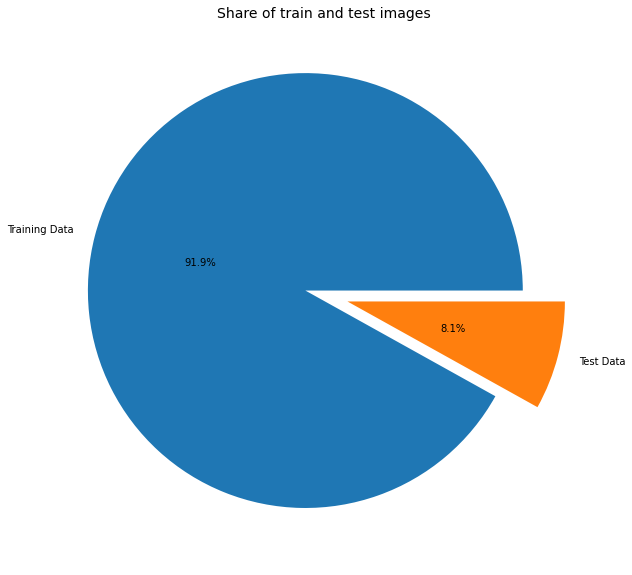

In [7]:
plt.figure(figsize=(15, 10))
plt.pie(x=np.array([train,test]), autopct="%.1f%%", explode=[0.1, 0.1], labels=["Training Data", "Test Data"], pctdistance=0.5)
plt.title("Share of train and test images ", fontsize=14);

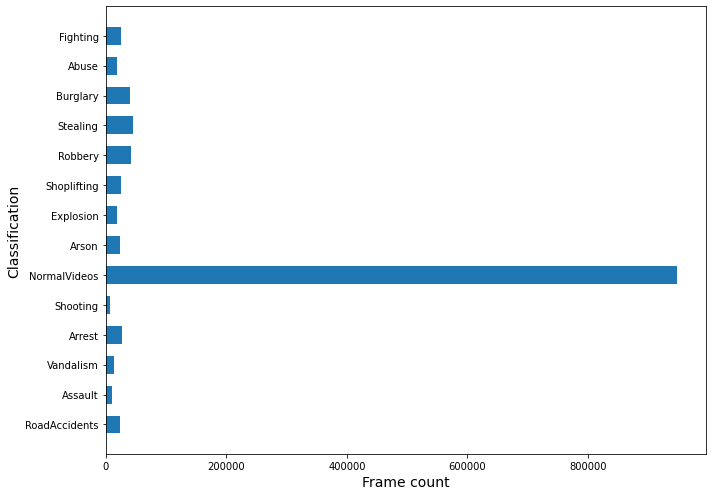

In [8]:
plt.figure(figsize=(10, 7))
plt.barh(list(crimes.keys()), list(crimes.values()), height=0.6, align="center")
plt.yticks(rotation=0)

plt.xlabel("Frame count", fontsize=14)
plt.ylabel("Classification", fontsize=14)
plt.tight_layout()
plt.show()


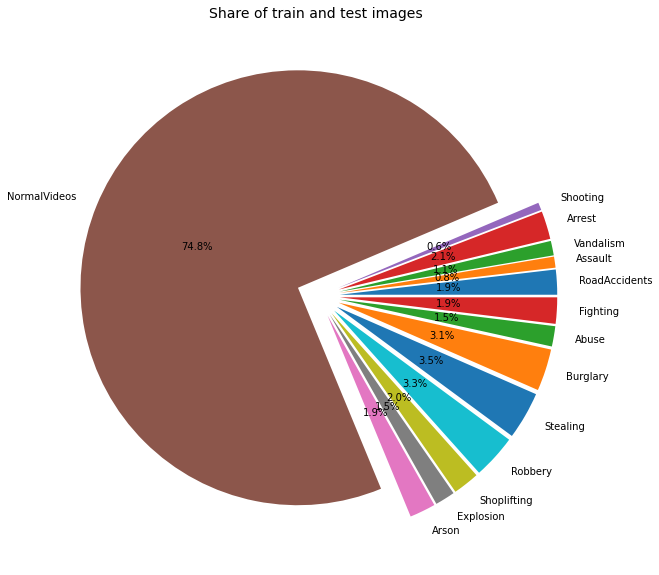

In [9]:
plt.figure(figsize=(15,10))
plt.pie(x=np.array(list(crimes.values())), autopct="%.1f%%", explode=[0.1]*n,labels=list(crimes.keys()), pctdistance=0.5)
plt.title("Share of train and test images ", fontsize=14);

In [10]:
IMG_WIDTH=64
IMG_HEIGHT=64

IMG_SHAPE=(IMG_HEIGHT,IMG_WIDTH)
seed=69

INPUT_SHAPE=(IMG_HEIGHT,IMG_WIDTH,3)

In [11]:
train_set=image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="training",
)

val_set=image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="validation",
)

test_set=image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    class_names=None,
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=False,
    seed=seed,
)

Found 1266345 files belonging to 14 classes.
Using 1013076 files for training.
Found 1266345 files belonging to 14 classes.
Using 253269 files for validation.
Found 111308 files belonging to 14 classes.


In [12]:
def transfer_learning():
    base_model=DenseNet121(include_top=False,input_shape=INPUT_SHAPE,weights="imagenet")
    
    thr=149
    for layers in base_model.layers[:thr]:
        layers.trainable=False
    
    for layers in base_model.layers[thr:]:
        layers.trainable=True
    
    return base_model

In [13]:
def create_model():
    model=Sequential()
    
    base_model=transfer_learning()
    model.add(base_model)
    
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.2))
    
    model.add(Dense(n,activation="softmax",name="classification"))
    
    model.summary()
    
    return model
    

In [14]:
model=create_model()

model.compile(optimizer="adam", 
                loss='categorical_crossentropy',
                metrics = [tf.keras.metrics.AUC()])

29097984/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 2, 2, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               131200    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
classification (Dense)       (None, 14)                1806      
Total params: 7,170,510
Trainable params: 5,586,254
Non-trainable params: 1,584,256
_________________________________________________________________


In [15]:
history = model.fit(x = train_set,validation_data=val_set,epochs = EPOCHS)

Epoch 1/5
31659/31659 [==============================] - 2583s 81ms/step - loss: 0.0812 - auc: 0.9987 - val_loss: 0.0182 - val_auc: 0.9997
Epoch 2/5
31659/31659 [==============================] - 2052s 65ms/step - loss: 0.0216 - auc: 0.9996 - val_loss: 0.0106 - val_auc: 0.9999
Epoch 3/5
31659/31659 [==============================] - 2010s 63ms/step - loss: 0.0155 - auc: 0.9998 - val_loss: 0.0103 - val_auc: 0.9998
Epoch 4/5
31659/31659 [==============================] - 1974s 62ms/step - loss: 0.0128 - auc: 0.9998 - val_loss: 0.0078 - val_auc: 0.9999
Epoch 5/5
31659/31659 [==============================] - 1962s 62ms/step - loss: 0.0111 - auc: 0.9998 - val_loss: 0.0082 - val_auc: 0.9999


In [16]:
y_true =  np.array([])

for x, y in test_set:
  y_true = np.concatenate([y_true, np.argmax(y.numpy(), axis=-1)])

In [17]:
y_pred=model.predict(test_set)

In [18]:
from sklearn.metrics import classification_report

# Convert y_pred to labels
y_pred_labels = np.argmax(y_pred, axis=-1)

# Generate classification report
report = classification_report(y_true, y_pred_labels)

print(report)


              precision    recall  f1-score   support

         0.0       0.01      0.07      0.02       297
         1.0       0.07      0.03      0.04      3365
         2.0       0.13      0.19      0.15      2793
         3.0       0.01      0.00      0.00      2657
         4.0       0.01      0.00      0.00      7657
         5.0       0.38      0.04      0.07      6510
         6.0       0.00      0.00      0.00      1231
         7.0       0.73      0.90      0.80     64952
         8.0       0.20      0.39      0.27      2663
         9.0       0.00      0.00      0.00       835
        10.0       0.00      0.00      0.00      7630
        11.0       0.52      0.02      0.03      7623
        12.0       0.11      0.20      0.14      1984
        13.0       0.08      0.17      0.11      1111

    accuracy                           0.55    111308
   macro avg       0.16      0.14      0.12    111308
weighted avg       0.50      0.55      0.49    111308



In [20]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(crime_types):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

ROC AUC score: 0.8344784183301716


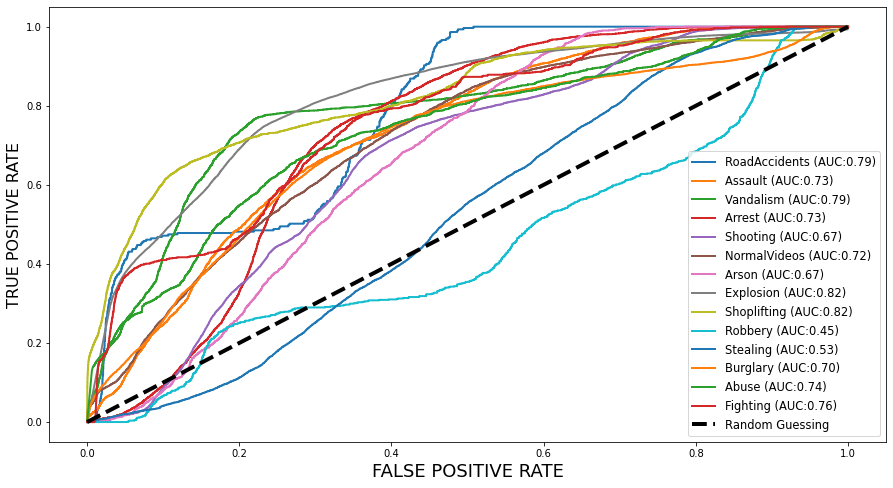

In [21]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))


print('ROC AUC score:', multiclass_roc_auc_score(y_true , y_pred  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [22]:
model.save("/kaggle/working/")

In [23]:
# Save the model in HDF5 format
model.save('/kaggle/working/trained_model.h5')

In [1]:
import tensorflow as tf

model=tf.keras.models.load_model("D:/MinorProject/trained_model.h5")

In [4]:
import cv2
import os
import numpy as np
from tensorflow.keras.preprocessing import image

IMG_WIDTH = 64
IMG_HEIGHT = 64
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)


def preprocess_frame(frame):
    # Resize frame to match model input shape
    frame = cv2.resize(frame, (IMG_WIDTH, IMG_HEIGHT))
    # Normalize pixel values to [0, 1]
    frame = frame / 255.0
    return frame

def predict_video(video_path):
    cap = cv2.VideoCapture(video_path)
    predictions = []
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Only process every 10th frame
        if frame_count % 10 == 0:
            processed_frame = preprocess_frame(frame)
            processed_frame = np.expand_dims(processed_frame, axis=0)
            prediction = model.predict(processed_frame)
            is_anomaly = prediction[0][1] > 0.05
            predictions.append(is_anomaly)

        frame_count += 1

    cap.release()

    return predictions


In [3]:
# Predict anomalies in the random video
VIDEO_PATH = "D:/MinorProject/Fighting/Fighting014_x264A.mp4"
anomaly_predictions = predict_video(VIDEO_PATH)

# Analyze the predictions
if any(anomaly_predictions):
    print("The video contains anomalies.")
else:
    print("The video is Normal.")

1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 80ms/step
The video contains anomalies.


In [5]:
# Predict anomalies in the random video
VIDEO_PATH =video_path = "D:/MinorProject/Normal/Normal_Videos_050_x264.mp4"
anomaly_predictions = predict_video(VIDEO_PATH)

# Analyze the predictions
if any(anomaly_predictions):
    print("The video contains anomalies.")
else:
    print("The video is Normal.")

1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 60ms/step
The video is Normal.
